In [49]:
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt 
from IPython.core.pylabtools import  figsize
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
sns.set()

%matplotlib inline

# A/Bテスト

## 事前確率

In [50]:
with pm.Model() as model:
    p=pm.Uniform('p',lower=0,upper=1)

## 観測データを生成するために、真の分布を構築

In [51]:
p_true=0.05 # 本当はわからない
N=1500 # 標本数

occ=stats.bernoulli.rvs(p_true,size=N)

print(occ)
print(occ.sum())

[0 0 0 ... 0 0 0]
74


## 事後分布のモデルを構築

In [52]:
with model:
    # 尤度
    obs=pm.Bernoulli('obs',p,observed=occ)
    step=pm.Metropolis()
    trace=pm.sample(18000,step=step)
    burned_trace=trace[1000:]

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [p]
Sampling 4 chains: 100%|██████████| 74000/74000 [00:10<00:00, 7310.31draws/s]
The number of effective samples is smaller than 25% for some parameters.


## 事後分布を可視化

/Users/hiroaki/.pyenv/versions/3.6.5/envs/pycoon365/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


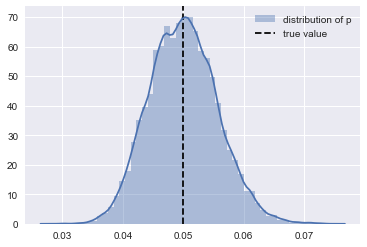

In [53]:
fig,ax=plt.subplots()
sns.distplot(a=burned_trace['p'],ax=ax,label='distribution of p')
ax.vlines(p_true,0,90,linestyles='--',label='true value')
ax.legend()

## AサイトとBサイトのCV数の比較

In [54]:
true_p_A=0.05
true_p_B=0.04


N_A=1500
N_B=750

occ_A=stats.bernoulli.rvs(true_p_A,size=N_A)
occ_B=stats.bernoulli.rvs(true_p_B,size=N_B)

print(obs_A.mean())
print(obs_B.mean())

mean
mean


### モデル構築


In [55]:
with pm.Model() as model:
    p_A=pm.Uniform('p_A',0,1)
    p_B=pm.Uniform('p_B',0,1)
    
    # p_Aとp_Bにより決定するので決定的
    delta=pm.Deterministic('delta',p_A-p_B)
    
    obs_A=pm.Bernoulli('obs_A',p_A,observed=occ_A)
    obs_B=pm.Bernoulli('obs_B',p_B,observed=occ_B)
    
    
    # 事後分布を計算
    step=pm.Metropolis()
    trace=pm.sample(20000,step=step)
    
    burned_trace=trace[1000:]
    
    

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:15<00:00, 5313.58draws/s]
The number of effective samples is smaller than 25% for some parameters.


/Users/hiroaki/.pyenv/versions/3.6.5/envs/pycoon365/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'delta')

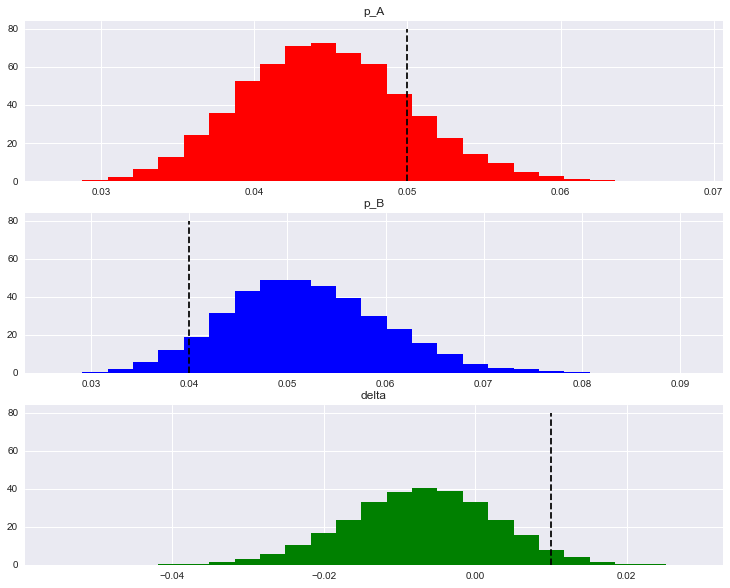

In [56]:
figsize(12.5,10)

ax1=plt.subplot(311)
ax1.hist(burned_trace['p_A'],bins=25,normed=True,color='r')
ax1.vlines(true_p_A,0,80,linestyles='--')
ax1.set_title('p_A')

ax2=plt.subplot(312)
ax2.hist(burned_trace['p_B'],bins=25,normed=True,color='b')
ax2.vlines(true_p_B,0,80,linestyles='--')
ax2.set_title('p_B')

ax3=plt.subplot(313)
ax3.hist(burned_trace['delta'],bins=25,normed=True,color='g')
ax3.vlines(true_p_A-true_p_B,0,80,linestyles='--')
ax3.set_title('delta')

# プライバシーアルゴリズム

In [96]:
# 生徒の人数
N=100

# 面接した結果、「はい」といった数
X=35

## モデル生成

In [99]:
with pm.Model() as model:
    p=pm.Uniform('freq_cheating',0,1) # カンニングをする割合(知りたい分布)
    
    # 本当の答え
    t_ans=pm.Bernoulli('truths',p,shape=N,testval=np.random.binomial(1,0.5,size=N))
    
    # 一回目のコイン
    fst_coin=pm.Bernoulli('fst',0.5,shape=N,testval=np.random.binomial(1,0.5,size=N))
    
    # 二回目のコイン
    scd_coin=pm.Bernoulli('scd',0.5,shape=N,testval=np.random.binomial(1,0.5,size=N))
   
    # プライバシーアルゴリズム
    val=fst_coin*t_ans+(1-fst_coin)*scd_coin
    obs_pro=pm.Deterministic('obs_pro',tt.sum(val)/float(N))
    
    
    # 尤度
    obs=pm.Binomial('obs',N,obs_pro,X)
    
    # 事後分布を計算
    step=pm.Metropolis(vars=[p])
    trace=pm.sample(40000,step=step)
    burned_trace=trace[15000:]
    

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [freq_cheating]
>BinaryGibbsMetropolis: [truths, fst, scd]
>Metropolis: [obs]
Sampling 4 chains: 100%|██████████| 162000/162000 [20:36<00:00, 131.00draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


/Users/hiroaki/.pyenv/versions/3.6.5/envs/pycoon365/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


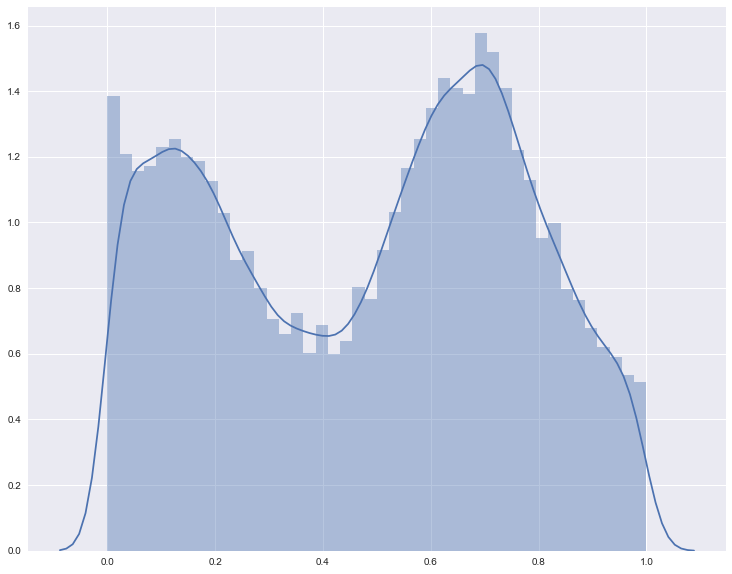

In [101]:
p_trace=burned_trace['freq_cheating'][15000:]
ax=sns.distplot(a=p_trace)

# チャレンジャー号の事故調査

## 観測結果

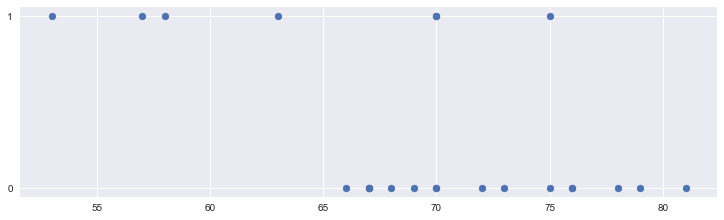

In [156]:
figsize(12.5, 3.5)
challenger_data=pd.read_csv('./dataset/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/Chapter2_MorePyMC/data/challenger_data.csv')
challenger_data=challenger_data.iloc[:-1,1:].dropna()
plt.scatter(challenger_data.iloc[:,0],challenger_data.iloc[:,1])



# モデル構築

In [157]:
# 観測データ
temp=challenger_data.iloc[:,0].values
D=challenger_data.iloc[:,1].values

In [158]:
with pm.Model() as model:
    beta=pm.Normal('beta',mu=0,tau=0.001,testval=0)
    alpha=pm.Normal('alpha',mu=0,tau=0.001,testval=0)
    
    # logistic(事前分布)
    p=pm.Deterministic('p',1.0/(1.+tt.exp(beta*temp+alpha)))
    
    # 尤度
    obs=pm.Bernoulli('bernoulli_obs',p,observed=D)
    
    # MCMC
    start=pm.find_MAP()
    step=pm.Metropolis()
    
    trace=pm.sample(12000,step=step,start=start)
    burned_trace=trace[10000::2]

logp = -19.024, ||grad|| = 9.9071: 100%|██████████| 27/27 [00:00<00:00, 1496.28it/s]  
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]
Sampling 4 chains: 100%|██████████| 50000/50000 [00:08<00:00, 5977.69draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


## パラメータを可視化

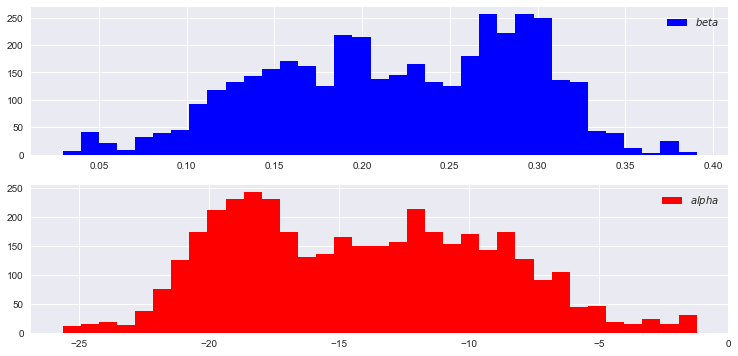

In [172]:
alpha_samples = burned_trace["alpha"][:, None]  # best to make them 1d
beta_samples = burned_trace["beta"][:, None]

figsize(12.5, 6)
ax1=plt.subplot(211)
ax2=plt.subplot(212)
ax1.hist(beta_samples,bins=35,label='$beta$',color='b')
ax2.hist(alpha_samples,bins=35,label='$alpha$',color='r')
ax1.legend()
ax2.legend()

## 得られたパラメータを平均することで、モデルを構築

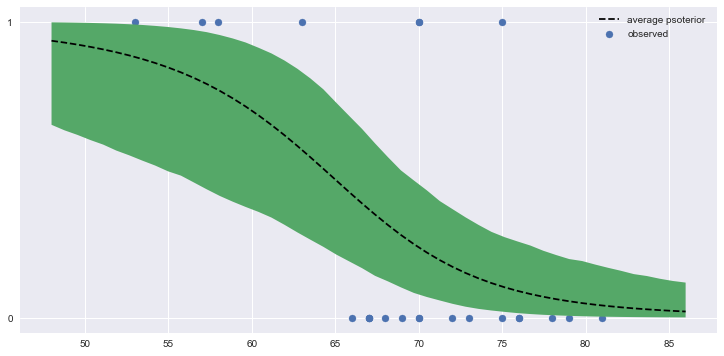

In [225]:
def logstic(x,beta,alpha):
    return 1.0/(1.0+np.exp(beta@x+alpha))


t=np.linspace(temp.min()-5,temp.max()+5)[:,None]
p_t=logstic(t.T,beta_samples,alpha_samples)

# 平均
m_p_t=np.mean(p_t,axis=0)
plt.scatter(temp,D,label='observed')
plt.plot(t,m_p_t,label='average psoterior ',color='k',ls='--')

# 95%確信区間を表示
qs=stats.mstats.mquantiles(p_t,[0.025,0.975],axis=0)
# qsをアンパックすることで、自動的に区間を渡せる
plt.fill_between(t[:,0],*qs)
plt.legend()

# いろいろ実験したやつ

In [57]:
with pm.Model() as det_test:
    def subtract(x, y):
        return x - y

    stochastic_1 = pm.Uniform("U_1", 0, 1)
    stochastic_2 = pm.Uniform("U_2", 0, 1)

    det_1 = pm.Deterministic("Delta", subtract(stochastic_1, stochastic_2))

In [58]:
type(det_1)

theano.tensor.var.TensorVariable

In [59]:
with pm.Model() as theano_test:
    p1=pm.Uniform('p',0,1)
    p2=1-p1
    p=tt.stack([p1,p2])
    
    asg=pm.Categorical('asg',p)

In [60]:
data = np.array([10, 25, 15, 20, 35])
with pm.Model() as model:
    obs = pm.Poisson("obs", pm.Uniform('p',0,1), observed=data)
print(obs.tag.test_value)

[10 25 15 20 35]
